--------

#### `In this notebook we divide image width and height by 5 before extracting features`
*img = img.resize((img.width // 5, img.height // 5))*

* Got exact same accuracy as with division by 2, but in less time
* Tried to use clustering to improve accuracy

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

## Import and Prepare Data

In [2]:
training_data = pd.read_csv('/root/ubc/train.csv')

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Select WSI images
non_tma_data_simple = training_data[training_data['is_tma'] == False]

# Sampling 40 images from each cancer type
balanced_data = non_tma_data_simple.groupby('label').sample(n=40, random_state=33)

# Adding a new column 'path' to the balanced dataset
balanced_data['path'] = balanced_data['image_id'].astype(str) + '.png'

balanced_data.reset_index(drop=True, inplace=True)

# Displaying the updated DataFrame
balanced_data

,image_id,label,image_width,image_height,is_tma,path
0,5970,CC,27265,22900,False,5970.png
1,64824,CC,46589,19365,False,64824.png
2,1952,CC,33685,38053,False,1952.png
3,59515,CC,64700,36387,False,59515.png
4,54928,CC,36166,31487,False,54928.png
...,...,...,...,...,...,...
195,48550,MC,32431,25393,False,48550.png
196,39252,MC,48980,40700,False,39252.png
197,47431,MC,67495,46563,False,47431.png
198,65094,MC,55042,45080,False,65094.png


In [4]:
# load features

'''import pickle

with open('/root/ubc_ocean/anar/extracted-features/main3_512px_resnet101_200.pkl', 'rb') as f:
    slide_features = pickle.load(f)

len(slide_features)'''

## Feature Extraction

In [4]:
import cv2
import timm
import torch
from torchvision import transforms
from PIL import Image, ImageFile
import zipfile
import os

# Assuming the ZIP file path and the root directory inside the ZIP
zip_path = '/root/UBC-OCEAN.zip'
zip_root_dir = 'train_images/'

# Increase the maximum number of pixels PIL can process
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load a pre-trained model for feature extraction
model = timm.create_model('resnet101', pretrained=True, num_classes=0)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to check if the tile has tissue present
def is_tissue_present(tile, area_threshold=0.55, low_saturation_threshold=20):   # 55% tissue
    hsv = cv2.cvtColor(tile, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, high_sat = cv2.threshold(s, low_saturation_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    tissue_mask = cv2.dilate(high_sat, kernel, iterations=2)
    tissue_mask = cv2.erode(tissue_mask, kernel, iterations=2)
    tissue_ratio = np.sum(tissue_mask > 0) / (tile_size * tile_size)
    return tissue_ratio > area_threshold

# Function to extract features from a tile
def extract_features(tile, model, transform):
    tile = Image.fromarray(tile)
    tile = transform(tile).unsqueeze(0)
    with torch.no_grad():
        features = model(tile)
    return features.squeeze(0).numpy()

# Function to process a patch of the image
def process_patch(patch, model, transform):
    if is_tissue_present(patch):
        features = extract_features(patch, model, transform)
        return features
    return None

# Define the size for the tiles
tile_size = 512

slide_features = {}

# Process each image, extract tiles, extract features, and store them
total_images = len(balanced_data)
for index, row in balanced_data.iterrows():
    #if index >= 173:
        # Stop after processing the first 50 images
       #continue

    tile_features = [] # List to hold the features for the current image

    # Extracting image from ZIP
    image_name = row['path']  # Adjust based on your DataFrame structure
    image_path = os.path.join(zip_root_dir, image_name)

    # Print the current status
    print(f"Processing image {index + 1} of {total_images}: {image_path}")
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extract(image_path, '/root/ubc_ocean/temp')
            extracted_image_path = os.path.join('/root/ubc_ocean/temp', image_path)

            with Image.open(extracted_image_path) as img:
                img = img.resize((img.width // 5, img.height // 5))

                for y in range(0, img.height, tile_size):
                    for x in range(0, img.width, tile_size):
                        # Read the patch
                        patch = img.crop((x, y, x + tile_size, y + tile_size))
                        patch = np.array(patch)  # Convert PIL Image to NumPy array

                        # Process the patch
                        features = process_patch(patch, model, transform)
                        if features is not None:
                            tile_features.append(features)

            # Delete the extracted image to save space
            os.remove(extracted_image_path)

        # Store the extracted features and the label in the slide_features_part1 dictionary
        slide_features[image_name] = {
            'features': tile_features,
            'label': row['label']
        }
    except Exception as e:
        print(f"Error processing image {image_name}: {e}")
    
    import pickle

    with open('/root/ubc_ocean/anar/extracted-features/main3_512px_resnet101_200.pkl', 'wb') as f:
        pickle.dump(slide_features, f)

Processing image 1 of 200: train_images/5970.png
Processing image 2 of 200: train_images/64824.png
Processing image 3 of 200: train_images/1952.png
Processing image 4 of 200: train_images/59515.png
Processing image 5 of 200: train_images/54928.png
Processing image 6 of 200: train_images/18014.png
Processing image 7 of 200: train_images/39880.png
Processing image 8 of 200: train_images/30369.png
Processing image 9 of 200: train_images/56861.png
Processing image 10 of 200: train_images/4827.png
Processing image 11 of 200: train_images/51346.png
Processing image 12 of 200: train_images/45725.png
Processing image 13 of 200: train_images/20205.png
Processing image 14 of 200: train_images/52461.png
Processing image 15 of 200: train_images/26219.png
Processing image 16 of 200: train_images/52259.png
Processing image 17 of 200: train_images/62828.png
Processing image 18 of 200: train_images/38687.png
Processing image 19 of 200: train_images/22489.png
Processing image 20 of 200: train_images/26

In [ ]:
# save features

"""import pickle

with open('/root/ubc_ocean/anar/extracted-features/main3_512px_resnet101_200.pkl', 'wb') as f:
    pickle.dump(slide_features, f)"""

In [ ]:
import pickle

with open('/root/ubc_ocean/anar/extracted-features/main3_512px_resnet101_200.pkl', 'rb') as f:
    slide_features = pickle.load(f)

len(slide_features)

---------------------

## Model Training (MIL Classifier)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random

# Set a fixed random state for reproducibility
random_state = 33

# Convert slide_features to a suitable format
data = [(features['features'], features['label']) for path, features in slide_features.items()]

# Organize data by labels
data_by_label = defaultdict(list)
for features, label in data:
    data_by_label[label].append((features, label))

# Split data for each label into train, validation, and test
train_data = []
val_data = []
test_data = []

for label, label_data in data_by_label.items():
    # Split data for this label into train and test with a fixed random state
    train_val_label_data, test_label_data = train_test_split(label_data, test_size=0.2, random_state=random_state)
    
    # Split train data into train and validation with a fixed random state
    train_label_data, val_label_data = train_test_split(train_val_label_data, test_size=0.125, random_state=random_state)  # 0.25 x 0.8 = 0.2 of original
    
    # Append split data to respective sets
    train_data.extend(train_label_data)
    val_data.extend(val_label_data)
    test_data.extend(test_label_data)

# Shuffle the datasets
random.seed(random_state)
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Function to check balance in each set
def check_balance(dataset):
    label_counts = defaultdict(int)
    for _, label in dataset:
        label_counts[label] += 1
    return dict(label_counts)

# Display balance of each set
print("Train balance:", check_balance(train_data))
print("Validation balance:", check_balance(val_data))
print("Test balance:", check_balance(test_data))

Train balance: {'CC': 28, 'EC': 28, 'LGSC': 28, 'HGSC': 28, 'MC': 28}
Validation balance: {'HGSC': 4, 'CC': 4, 'LGSC': 4, 'MC': 4, 'EC': 4}
Test balance: {'MC': 8, 'HGSC': 8, 'LGSC': 8, 'EC': 8, 'CC': 8}


In [ ]:
# Create a mapping from label strings to integers
unique_labels = sorted(set(label for _, label in data))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

class MILDataset(Dataset):
    def __init__(self, data, label_to_idx):
        self.data = data
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_vectors, label = self.data[idx]
        label_idx = self.label_to_idx[label]  # Convert label to integer
        return torch.tensor(feature_vectors), torch.tensor(label_idx, dtype=torch.float32)

# Create Datasets for train, validation, and test
train_dataset = MILDataset(train_data, label_to_idx)
val_dataset = MILDataset(val_data, label_to_idx)
test_dataset = MILDataset(test_data, label_to_idx)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [19]:
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(AttentionMIL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=0)
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)  # num_classes instead of 1

    def forward(self, bag):
        h = torch.relu(self.fc1(bag))
        a = self.attention(h)
        v = torch.sum(a * h, dim=0)
        y = self.classifier(v)  # Remove softmax here; output raw scores
        return y, a

# Number of unique classes
num_classes = len(unique_labels)

model = AttentionMIL(input_dim=2048, hidden_dim=256, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early Stopping Parameters
best_val_loss = float('inf')
patience = 4
patience_counter = 0

# Model Training with Validation
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop
    for bags, labels in train_loader:
        optimizer.zero_grad()

        if bags.nelement() == 0:  # Check if the bag is empty
            continue

        #print("Bags shape:", bags.shape)  # Add this line for debugging
        #print("Labels shape:", labels.shape)  # Add this line for debugging

        # Select the first bag in the batch
        bags = bags[0]  # bags now has the shape [75, 2048]
        # For labels, the following line should work fine
        labels = labels.squeeze(0).long()
    
        output, _ = model(bags)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 0)
        train_total += 1
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for bags, labels in val_loader:
            if bags.nelement() == 0:  # Check if the bag is empty
                continue

            bags = bags.squeeze(0)
            labels = labels.squeeze(0).long()
            output, _ = model(bags)
            loss = loss_function(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 0)
            val_total += 1
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    
    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/15, Train Loss: 1.5941, Train Acc: 25.18%, Validation Loss: 1.5738, Val Acc: 30.00%
Epoch 2/15, Train Loss: 1.4125, Train Acc: 42.45%, Validation Loss: 1.4646, Val Acc: 45.00%
Epoch 3/15, Train Loss: 1.1442, Train Acc: 59.71%, Validation Loss: 1.3806, Val Acc: 40.00%
Epoch 4/15, Train Loss: 0.9198, Train Acc: 67.63%, Validation Loss: 1.3389, Val Acc: 40.00%
Epoch 5/15, Train Loss: 0.6746, Train Acc: 79.14%, Validation Loss: 1.5429, Val Acc: 45.00%
Epoch 6/15, Train Loss: 0.5876, Train Acc: 79.86%, Validation Loss: 1.3964, Val Acc: 55.00%
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15, Train Loss: 0.4692, Train Acc: 84.17%, Validation Loss: 1.4897, Val Acc: 60.00%
Stopping early due to no improvement in validation loss.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for bags, labels in test_loader:
        output, _ = model(bags.squeeze(0))
        _, predicted_labels = torch.max(output, 0)  # Get the index of the max log-probability
        predictions.append(predicted_labels.item())  # Append scalar value
        true_labels.append(labels.squeeze(0).item())  # Append scalar value

# Convert lists to arrays for metric calculation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7000
Precision: 0.7062
Recall: 0.7000
F1 Score: 0.6948


In [ ]:
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Use idx_to_label to map numeric predictions back to label names
predicted_labels = [idx_to_label[int(idx)] for idx in predictions]
true_label_names = [idx_to_label[int(idx)] for idx in true_labels]

# Now predicted_labels and true_label_names contain the label names
print(predicted_labels)
print(true_label_names)

['MC', 'LGSC', 'EC', 'LGSC', 'LGSC', 'HGSC', 'HGSC', 'LGSC', 'HGSC', 'HGSC', 'EC', 'EC', 'LGSC', 'LGSC', 'MC', 'LGSC', 'CC', 'HGSC', 'EC', 'CC', 'CC', 'HGSC', 'CC', 'LGSC', 'MC', 'LGSC', 'MC', 'EC', 'HGSC', 'MC', 'MC', 'CC', 'CC', 'LGSC', 'MC', 'EC', 'HGSC', 'MC', 'LGSC', 'EC']
['MC', 'HGSC', 'HGSC', 'LGSC', 'LGSC', 'HGSC', 'EC', 'LGSC', 'HGSC', 'HGSC', 'EC', 'MC', 'LGSC', 'LGSC', 'EC', 'EC', 'CC', 'EC', 'EC', 'CC', 'CC', 'HGSC', 'CC', 'HGSC', 'MC', 'LGSC', 'MC', 'EC', 'CC', 'MC', 'MC', 'CC', 'CC', 'LGSC', 'EC', 'CC', 'HGSC', 'MC', 'LGSC', 'MC']


In [20]:
torch.save(model.state_dict(), 'models/main3_model.pth')

---------------------------

## Adding clustering knowledge to improve models performance 
`(not worked as expected)`

In [21]:
train_features = []
train_labels = []

# Iterate over the training data to aggregate features and labels
for bag, label in train_data:
    for feature_vector in bag:
        train_features.append(feature_vector)
        train_labels.append(label)

# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [ ]:
import umap

# UMAP on training data features
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
umap_embedding_train = umap_reducer.fit_transform(train_features)

In [75]:
import hdbscan
# Adjust HDBSCAN parameters
min_cluster_size = 200  # Increase for larger minimum cluster size
min_samples = 8  # Increase to reduce noise
epsilon = 0.12  # Adjust based on distance threshold
alpha = 1.0  # Adjust density threshold for cluster formation

# Clustering with HDBSCAN
cluster_labels_train = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon,
                                       alpha=alpha, gen_min_span_tree=True).fit_predict(umap_embedding_train)

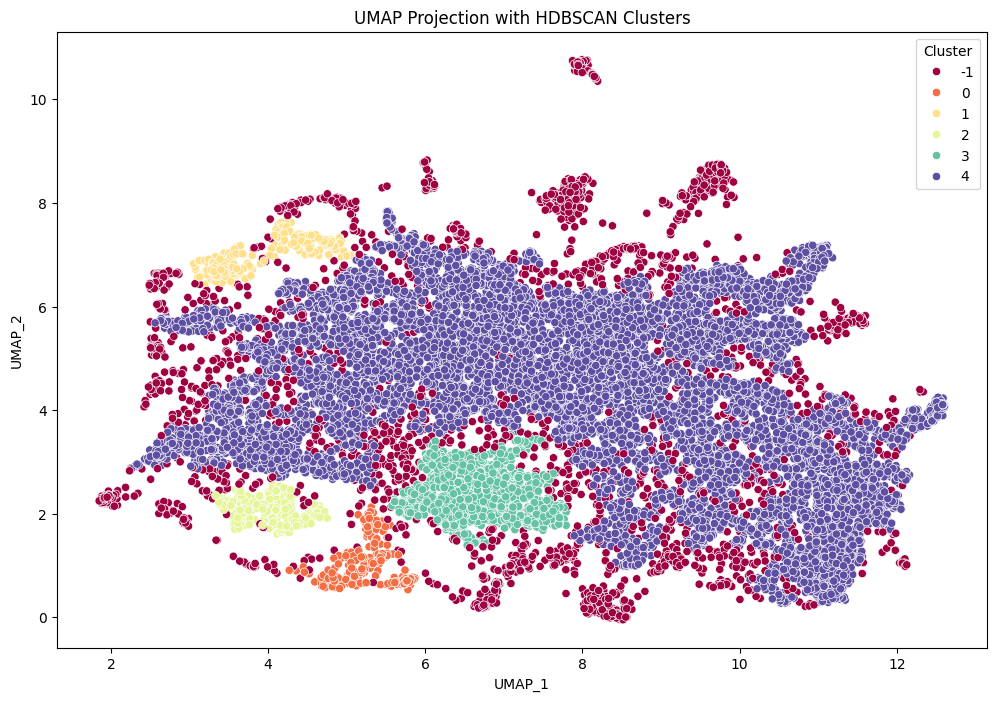

In [76]:
# Convert the UMAP embedding and cluster labels to a pandas DataFrame for plotting
columns = [f'UMAP_{i+1}' for i in range(umap_embedding_train.shape[1])]
embedding_df_train = pd.DataFrame(umap_embedding_train, columns=columns)
embedding_df_train['Cluster'] = cluster_labels_train

# Plot using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df_train, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Spectral')
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.show()

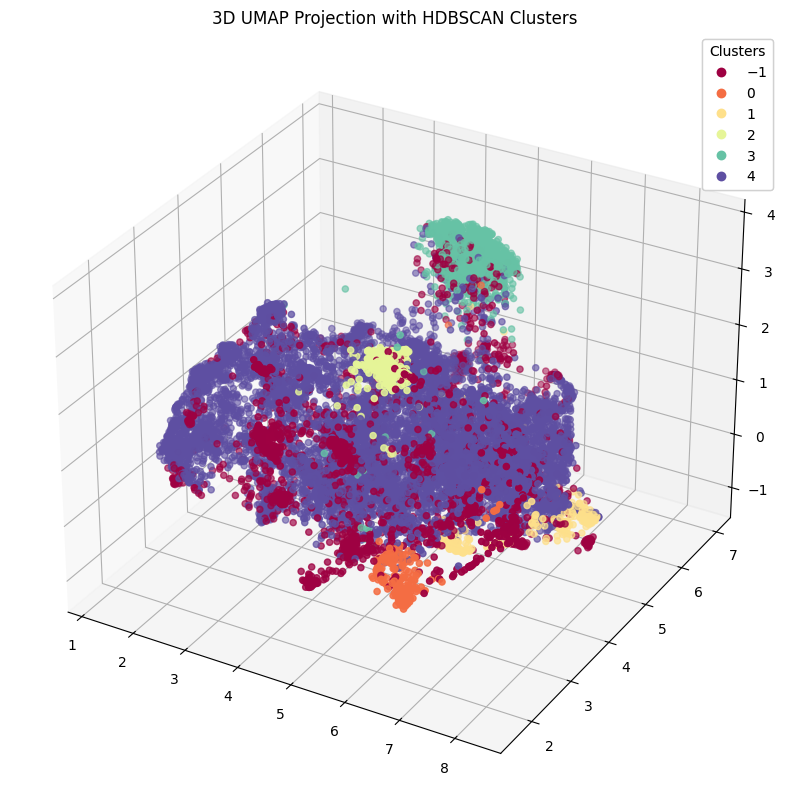

In [77]:
from mpl_toolkits.mplot3d import Axes3D

# Create a UMAP instance for 3D projection
umap_3d = umap.UMAP(n_neighbors=50, n_components=3, min_dist=0.01, metric='cosine')
umap_embedding_3d = umap_3d.fit_transform(train_features)

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(umap_embedding_3d[:, 0], umap_embedding_3d[:, 1], umap_embedding_3d[:, 2], c=cluster_labels_train, cmap='Spectral')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.title("3D UMAP Projection with HDBSCAN Clusters")
plt.show()

Cluster -1 label distribution:
Original_Label
CC      661
HGSC    623
LGSC    585
MC      384
EC      326
Name: count, dtype: int64



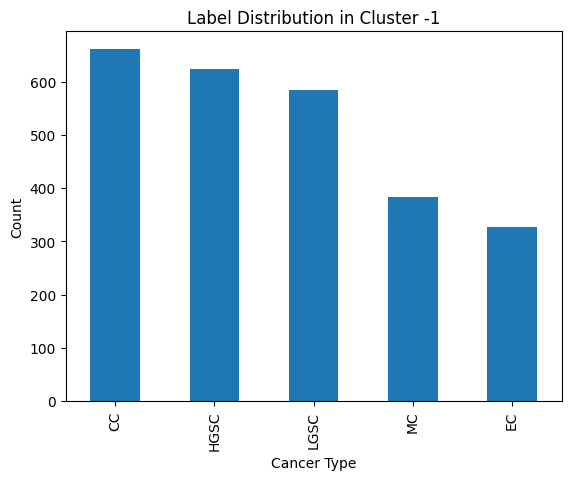

Cluster 0 label distribution:
Original_Label
HGSC    248
LGSC     13
EC        6
MC        5
Name: count, dtype: int64



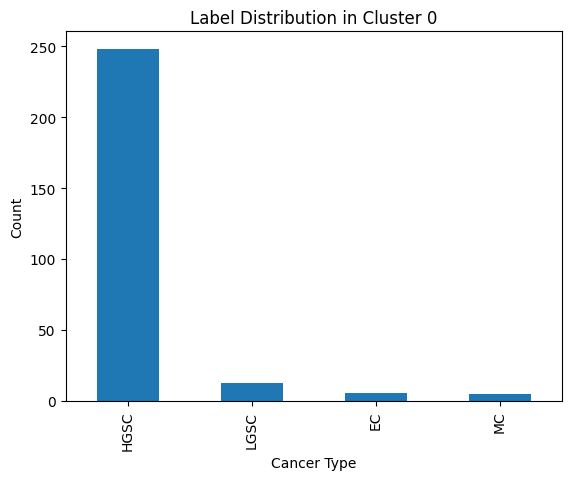

Cluster 1 label distribution:
Original_Label
LGSC    152
EC       84
HGSC     32
MC        7
CC        4
Name: count, dtype: int64



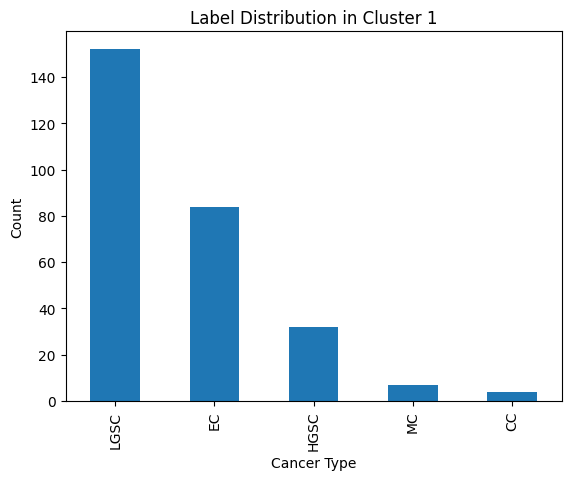

Cluster 2 label distribution:
Original_Label
CC    304
MC      1
Name: count, dtype: int64



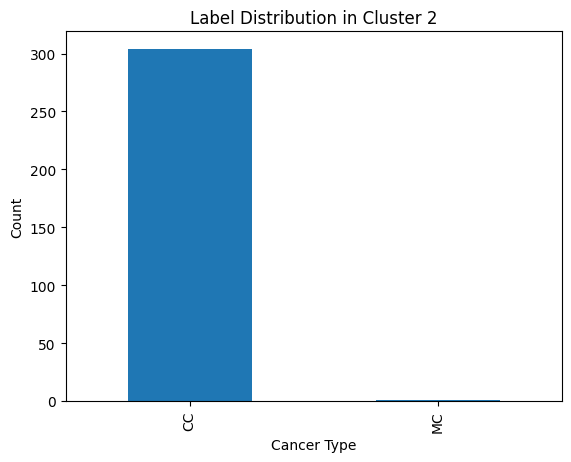

Cluster 3 label distribution:
Original_Label
CC      297
HGSC    249
EC      224
LGSC    192
MC      189
Name: count, dtype: int64



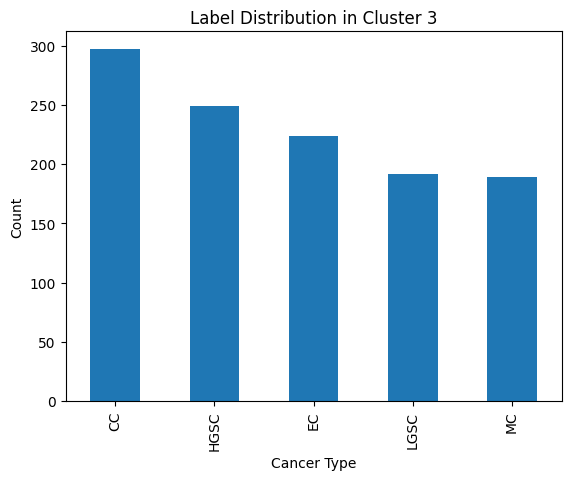

Cluster 4 label distribution:
Original_Label
MC      2950
EC      2100
CC      1932
HGSC    1324
LGSC    1199
Name: count, dtype: int64



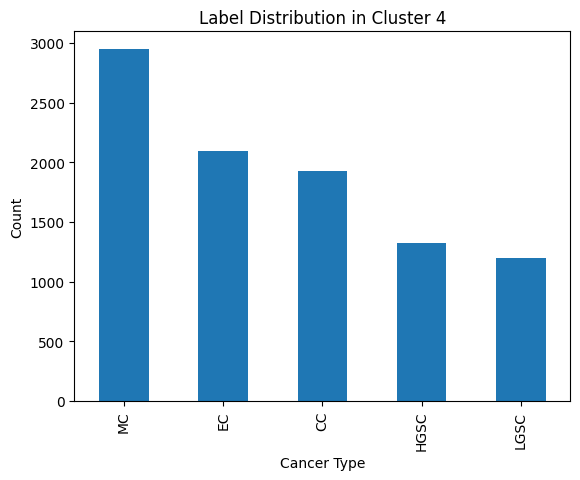

In [78]:
# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df_train['Original_Label'] = train_labels

# Analyze the labels for each cluster
for cluster in range(-1, 5):  # Assuming clusters are numbered 0 to 4
    cluster_data_train = embedding_df_train[embedding_df_train['Cluster'] == cluster]
    label_counts = cluster_data_train['Original_Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()

In [87]:
####
####  OLD APPROACH
####

from collections import defaultdict
import numpy as np

num_representatives = 10 # Number of representatives to select from each cluster
representative_features = defaultdict(list)

# Clusters to exclude
excluded_clusters = [-1, 1, 3, 4]

# Iterating through unique clusters
for cluster in np.unique(cluster_labels_train):
    if cluster not in excluded_clusters:
        cluster_indices = np.where(cluster_labels_train == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, num_representatives, replace=False)
        for idx in selected_indices:
            representative_features[cluster].append(train_features[idx])

# representative_features now holds the selected feature vectors for each cluster
    
####  OLD APPROACH

In [ ]:
# Augmenting the training data with representatives
augmented_train_data = []

for bag_features, label in train_data:
    augmented_bag = bag_features.copy()

    # Add representatives from each cluster to the bag
    for cluster_reps in representative_features.values():
        augmented_bag.extend(cluster_reps)

    augmented_train_data.append((augmented_bag, label))

# Optional: Print out the distribution of the number of representatives per cluster
for cluster, reps in representative_features.items():
    print(f"Cluster {cluster}: {len(reps)} representatives added")

In [83]:
# Create a mapping from label strings to integers
unique_labels = sorted(set(label for _, label in data))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

class MILDataset(Dataset):
    def __init__(self, data, label_to_idx):
        self.data = data
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_vectors, label = self.data[idx]
        label_idx = self.label_to_idx[label]  # Convert label to integer
        return torch.tensor(feature_vectors), torch.tensor(label_idx, dtype=torch.float32)

# Creating the datasets with augmented training data
train_dataset = MILDataset(augmented_train_data, label_to_idx)
val_dataset = MILDataset(val_data, label_to_idx)
test_dataset = MILDataset(test_data, label_to_idx)

# DataLoaders remain the same
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [84]:
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(AttentionMIL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=0)
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)  # num_classes instead of 1

    def forward(self, bag):
        h = torch.relu(self.fc1(bag))
        a = self.attention(h)
        v = torch.sum(a * h, dim=0)
        y = self.classifier(v)  # Remove softmax here; output raw scores
        return y, a

# Number of unique classes
num_classes = len(unique_labels)

model = AttentionMIL(input_dim=2048, hidden_dim=256, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early Stopping Parameters
best_val_loss = float('inf')
patience = 4
patience_counter = 0

# Model Training with Validation
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop
    for bags, labels in train_loader:
        optimizer.zero_grad()

        if bags.nelement() == 0:  # Check if the bag is empty
            continue

        #print("Bags shape:", bags.shape)  # Add this line for debugging
        #print("Labels shape:", labels.shape)  # Add this line for debugging

        # Select the first bag in the batch
        bags = bags[0]  # bags now has the shape [75, 2048]
        # For labels, the following line should work fine
        labels = labels.squeeze(0).long()
    
        output, _ = model(bags)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 0)
        train_total += 1
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for bags, labels in val_loader:
            if bags.nelement() == 0:  # Check if the bag is empty
                continue

            bags = bags.squeeze(0)
            labels = labels.squeeze(0).long()
            output, _ = model(bags)
            loss = loss_function(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 0)
            val_total += 1
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    
    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/15, Train Loss: 1.6277, Train Acc: 18.57%, Validation Loss: 1.6027, Val Acc: 35.00%
Epoch 2/15, Train Loss: 1.6001, Train Acc: 26.43%, Validation Loss: 1.5837, Val Acc: 30.00%
Epoch 3/15, Train Loss: 1.5423, Train Acc: 29.29%, Validation Loss: 1.5332, Val Acc: 45.00%
Epoch 4/15, Train Loss: 1.3467, Train Acc: 50.00%, Validation Loss: 1.4468, Val Acc: 40.00%
Epoch 5/15, Train Loss: 1.1838, Train Acc: 52.86%, Validation Loss: 1.3852, Val Acc: 35.00%
Epoch 6/15, Train Loss: 1.0601, Train Acc: 60.71%, Validation Loss: 1.4501, Val Acc: 45.00%
Epoch 7/15, Train Loss: 0.9128, Train Acc: 68.57%, Validation Loss: 1.3442, Val Acc: 50.00%
Epoch 8/15, Train Loss: 0.7381, Train Acc: 76.43%, Validation Loss: 1.3127, Val Acc: 50.00%
Epoch 9/15, Train Loss: 0.6176, Train Acc: 78.57%, Validation Loss: 1.3037, Val Acc: 70.00%
Epoch 10/15, Train Loss: 0.5193, Train Acc: 85.71%, Validation Loss: 1.4934, Val Acc: 50.00%
Epoch 11/15, Train Loss: 0.3949, Train Acc: 90.71%, Validation Loss: 1.5697, Va

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for bags, labels in test_loader:
        output, _ = model(bags.squeeze(0))
        _, predicted_labels = torch.max(output, 0)  # Get the index of the max log-probability
        predictions.append(predicted_labels.item())  # Append scalar value
        true_labels.append(labels.squeeze(0).item())  # Append scalar value

# Convert lists to arrays for metric calculation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6000
Precision: 0.6099
Recall: 0.6000
F1 Score: 0.6032


In [86]:
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Use idx_to_label to map numeric predictions back to label names
predicted_labels = [idx_to_label[int(idx)] for idx in predictions]
true_label_names = [idx_to_label[int(idx)] for idx in true_labels]

# Now predicted_labels and true_label_names contain the label names
print(predicted_labels)
print(true_label_names)

['MC', 'HGSC', 'EC', 'LGSC', 'LGSC', 'HGSC', 'LGSC', 'LGSC', 'HGSC', 'MC', 'MC', 'EC', 'LGSC', 'EC', 'MC', 'EC', 'EC', 'HGSC', 'HGSC', 'CC', 'CC', 'CC', 'CC', 'HGSC', 'MC', 'LGSC', 'EC', 'EC', 'HGSC', 'MC', 'MC', 'CC', 'CC', 'LGSC', 'EC', 'MC', 'CC', 'MC', 'LGSC', 'EC']
['MC', 'HGSC', 'HGSC', 'LGSC', 'LGSC', 'HGSC', 'EC', 'LGSC', 'HGSC', 'HGSC', 'EC', 'MC', 'LGSC', 'LGSC', 'EC', 'EC', 'CC', 'EC', 'EC', 'CC', 'CC', 'HGSC', 'CC', 'HGSC', 'MC', 'LGSC', 'MC', 'EC', 'CC', 'MC', 'MC', 'CC', 'CC', 'LGSC', 'EC', 'CC', 'HGSC', 'MC', 'LGSC', 'MC']
